In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import roc_auc_score

from sklearn import set_config; set_config(display='diagram')

# Create clean dataframe


## Load dataset

In [2]:
df = pd.read_csv("../../data-cleaned/compas-scores-two-years-clean.csv")

## Filter dataset

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [3]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

- Since most of the columns in the dataset describe charges after the initial COMPAS screening. Therefore these columns can not be used as predictors. 
- Furthermore we compared the original questionaire for the COMPAS scoring with the data of our datasets: 
- From the X sections in the original questionaire we only have data about demographics, criminal history and current charges from the defendant. 

In [4]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant fro feature engineering)
           "two_year_recid"] #target for classification 
df_clean = df[columns]

## Check values and dtypes of columns

In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


# Feature Engineering: Create feature `c_charge_degree_detailed`

- The current charges of the ProPublica dataset are categorized as felonies or misdemeanors `c_charge_degreee``
- The `c_charge_desc` contains the description of the crime (e.g. murder, Grand theft ...)
- In Florida each crime is based on the severness categorised into different level/ classes of misdemeanors or felonies

In [6]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df_clean.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df_clean[df_clean["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df_clean[df_clean["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
- The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
- We first used these crimes and map them against the current charges 

In [7]:
# check unique values/ classes of charges 
df_clean.r_charge_degree.unique()

array([nan, '(F3)', '(M1)', '(F2)', '(M2)', '(MO3)', '(F1)', '(F6)',
       '(F7)', '(CO3)', '(F5)'], dtype=object)

In [8]:
# Create lookup table for c_charge_degree_detailed based on c_charge_desc
lookup_c_charge_degree = pd.merge(
    df_clean[["c_charge_desc"]], 
    df_clean[
        (df_clean["r_charge_degree"]!='(MO3)') & #filter out classes of felonies and misdemeanors who do not exist
        (df_clean["r_charge_degree"]!='(F6)') &
        (df_clean["r_charge_degree"]!='(F7)') &
        (df_clean["r_charge_degree"]!='(CO3)') & 
        (df_clean["r_charge_degree"]!='(F5)') &
        (df_clean["r_charge_degree"]!=np.nan)
        ][["r_charge_degree", "r_charge_desc"]], 
    left_on="c_charge_desc", 
    right_on="r_charge_desc")

In [9]:
#drop duplicated c_charge_desc so we end up with unique charges and degrees
lookup_c_charge_degree = lookup_c_charge_degree[["c_charge_desc", "r_charge_degree"]].drop_duplicates()
lookup_c_charge_degree.columns = ["c_charge_desc", "c_charge_degree_detailed"]

#reset index 
lookup_c_charge_degree = lookup_c_charge_degree.reset_index(drop=True)
lookup_c_charge_degree

,c_charge_desc,c_charge_degree_detailed
0,Felony Battery w/Prior Convict,(F3)
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
...,...,...
169,Deliver Cannabis 1000FTSch,(F2)
170,Sex Batt Faml/Cust Vict 12-17Y,(F1)
171,Possession Of Clonazepam,(F3)
172,Deliver Cocaine 1000FT School,(F1)


In [10]:
#Find charges which do have multiple charge_degrees
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
12,Susp Drivers Lic 1st Offense,(M2)
13,Susp Drivers Lic 1st Offense,(M1)
29,False Ownership Info/Pawn Item,(F3)
30,False Ownership Info/Pawn Item,(F2)
36,Petit Theft,(M2)
37,Petit Theft,(M1)


In [11]:
#Decide for one degree for each duplicate -> we keep the harder class degrees (based on online research)
rows_to_drop = [2, 4, 12, 13, 29, 36, 43, 53, 65, 88]

#drop rows based on index 
lookup_c_charge_degree = lookup_c_charge_degree.drop(index=rows_to_drop)

In [12]:
#check that there are no more duplicates 
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed


In [13]:
#set index to c_charge_desc and drop row with c_charge_desc = NaN
lookup_c_charge_degree.set_index("c_charge_desc", inplace=True)
lookup_c_charge_degree = lookup_c_charge_degree[lookup_c_charge_degree.index.notnull()]

#Remove parenthesis from the labels 
lookup_c_charge_degree["c_charge_degree_detailed"] = lookup_c_charge_degree.c_charge_degree_detailed.str.strip("( )")

In [14]:
#Use lookup table to label charges based on description
charges_to_label = df_clean.merge(lookup_c_charge_degree, how="left", left_on="c_charge_desc", right_index=True)

In [15]:
charges_to_label[charges_to_label["c_charge_degree_detailed"].notna()].shape

(4099, 17)

- 4099 of the 5304 cases could be labeled automatically based on the r_charge_degree 
- The remaining charges need to be labeled manually

## Create list for charges which could not be matched automatically and need to be labeled manually

In [16]:
#Filter for rows which could not be labeled by the current lookup table (because they did not exist in r_charge_desc)
charges_to_label = charges_to_label[charges_to_label["c_charge_degree_detailed"].isnull()]

In [17]:
# Create list of unique charges which could not be labeled. These charges need to be labeled manually (online research)
charges_to_label_list = charges_to_label.groupby("c_charge_desc")[["id"]].count().sort_values(by="id", ascending=False)
charges_to_label_list["c_charge_degree_detailed"]=""
charges_to_label_list.columns = ['count', 'c_charge_degree_detailed']

charges_to_label_list

,count,c_charge_degree_detailed
c_charge_desc,,
arrest case no charge,684,
Felony Driving While Lic Suspd,73,
Susp Drivers Lic 1st Offense,45,
Aggravated Assault w/Firearm,20,
Poss Contr Subst W/o Prescript,15,
...,...,...
False Name By Person Arrest,1,
Falsely Impersonating Officer,1,
Grand Theft of a Fire Extinquisher,1,


There are 684 cases where the defendant wasn't pressed with charges. These cases will be decoded as `0`

In [18]:
# Export to .csv file so the charges can be labeled manually (only has to be executed once)
# charges_to_label_list.to_csv("charges_to_label.csv")

## Import manually labeld .csv file and combine with `lookup_c_charge_degree` to create master lookup table

In [19]:
# import labeled data
labeled_charges_man = pd.read_csv("charges_labeled_man.csv", index_col=0).set_index("c_charge_desc")[["c_charge_degree_detailed"]]

In [20]:
#Create master lookup table by combining manually labeled data with automatically labeled data
lookup_c_charge_degree_master = pd.concat([lookup_c_charge_degree, labeled_charges_man], axis=0)

In [21]:
# Save master lookup table as .csv so it can be imported directly (only has to be executed once)
#lookup_c_charge_degree_master.to_csv("labeled_charges_master.csv")

## Map charge degree to all cases and store in new feature column `c_charge_degree_detailed`

In [22]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [23]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df_clean = df_clean.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df_clean.reset_index(drop=True, inplace=True)

In [24]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df_clean[df_clean.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [25]:
index_nan_cases = df_clean[df_clean.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges. 
- These 5 cases need to be imputed
- This requires the encoding of all categorical features first

# Classification model of general recidivism

## Data preprocessing

### Select relevant features and perform train_test_split

In [26]:
#Select features for Classification model of general recidivism
# Select age or age_cat, exclude/ include race
columns_clas = ["age", "age_cat", "sex", #"race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas = df_clean[columns_clas].copy()

X = df_clas.drop(columns="two_year_recid")
y = df_clas["two_year_recid"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

### Create preprocessing pipeline

- `preproc_numerical` to impute and scale features
- `preproc_ordinal` to ordinaly encode `
- `preproc_nominal` to one hot encode the other ones (only relevant when race would be a feature)

In [28]:
feat_ordinal_dict = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
    "sex": ["Male","Female"]
    }

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal = make_pipeline(
    encoder_ordinal,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['Less than 25', '25 - 45',
                                             'Greater than 45'],
                                            ['M', 'F'],
                                            ['0', 'M2', 'M1', 'F3', 'F2', 'F1'],
                                            ['Male', 'Female']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('knnimputer', KNNImputer(missing_values=-1, n_neighbors=25)),
                ('minmaxscaler', MinMaxScaler())])

In [29]:
# Define numerical feature once-for-all
#from sklearn.compose import make_column_selector
#feat_numerical = make_column_selector(dtype_include='number')

feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

In [30]:
# # Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
# #only relevant for race feature -> therefore commented out 
# feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

# preproc_nominal = make_pipeline(
#     SimpleImputer(strategy="most_frequent"),
#     OneHotEncoder(drop="first", handle_unknown="ignore")
# )

In [31]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
#    (preproc_nominal, feat_nominal), (only needed when race a Feature)
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2',
                                                                              'M1',
                                                                              'F3',
                                                                              'F2',
                                                                              'F1'],
                                                                             ['Male',
                                                                              'Female']],
                                                                 dtype=<class 'numpy.int64'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed', 'sex'])])

In [32]:
#Test preproc pipeline
column_nam = feat_numerical + feat_ordinal#+list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

test = pd.DataFrame(preproc.fit_transform(df_clean), columns=column_nam)

test.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex
0,0.649351,0.0,0.0,0.000000,0.000000,1.0,1.0,0.6,0.0
1,0.194805,0.0,0.0,0.000000,0.000000,0.5,1.0,0.6,0.0
2,0.064935,0.0,0.0,0.111111,0.108108,0.0,1.0,0.6,0.0
3,0.324675,0.0,0.0,0.000000,0.000000,0.5,0.0,0.4,0.0
4,0.285714,0.0,0.0,0.000000,0.378378,0.5,1.0,0.6,0.0


In [33]:
##Test knnImputing of missing values 

# test.loc[index_nan_cases]
# test["c_charge_degree_detailed"]= test.c_charge_degree_detailed.apply(np.ceil)
# test.loc[index_nan_cases]

## Basinline model: Logistic regression

In [64]:
model = LogisticRegression()
pipe_log = make_pipeline(preproc, model)

In [50]:
#Grid Search
param_grid =  {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)
              }

search_log = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

search_log.fit(X_train, y_train);
print(search_log.best_params_)
search_log.best_score_

{'logisticregression__C': 1.2000000000000002, 'logisticregression__l1_ratio': 1.0, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


-0.5822621320575149

In [51]:
y_pred = search_log.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6433111093042795

In [52]:
confusion_matrix(y_test, y_pred)

array([[911,  93],
       [365, 223]])

In [53]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.71      0.91      0.80      1004
    is_recid       0.71      0.38      0.49       588

    accuracy                           0.71      1592
   macro avg       0.71      0.64      0.65      1592
weighted avg       0.71      0.71      0.69      1592



### Model iteration: Try out different solvers fro Logistic regression model

In [132]:
#Grid Search
param_grid =  {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.2,2.9,100),
              }

search_log_2 = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

search_log_2.fit(X_train, y_train);
print(search_log_2.best_params_)
search_log_2.best_score_

{'logisticregression__C': 2.7444444444444445, 'logisticregression__solver': 'lbfgs'}


-0.5825445213945968

In [133]:
y_pred = search_log_2.predict(X_test)

roc_auc_score(y_test, y_pred)

0.644100468872808

In [134]:
confusion_matrix(y_test, y_pred)

array([[916,  88],
       [367, 221]])

In [135]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.71      0.91      0.80      1004
    is_recid       0.72      0.38      0.49       588

    accuracy                           0.71      1592
   macro avg       0.71      0.64      0.65      1592
weighted avg       0.71      0.71      0.69      1592



## Multivariate feature selection based on their combined relationship with target `y`

- Some of the columns are different representations of the same data (eg. age and age_cat) and are therfore highly correlated
- Furthermore we want to remove features that, when in combination with all the others, do not really help predict our target

### Forward Selection using `SequentialFeatureSelector` 

In [65]:
sfs_forward = SequentialFeatureSelector(model)

In [66]:
pipe_sfs = make_pipeline(preproc, sfs_forward)

In [67]:
pipe_sfs.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                              ['Male',
                                                                                               'Female']],
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(estimator=LogisticRegression()))])

In [136]:
X.columns[pipe_sfs["sequentialfeatureselector"].get_support()]

Index(['age', 'juv_misd_count', 'priors_count', 'c_charge_degree_detailed'], dtype='object')

In [70]:
pipe_sfs_log = make_pipeline(pipe_sfs, model)

In [75]:
#Grid Search
param_grid =  {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)
              }

grid_sfs_log = GridSearchCV(pipe_sfs_log, param_grid, 
                          cv=10, n_jobs=-1, scoring="neg_log_loss")

grid_sfs_log.fit(X_train, y_train);
print(grid_sfs_log.best_params_)
grid_sfs_log.best_score_

{'logisticregression__C': 1.2222222222222223, 'logisticregression__l1_ratio': 1.0, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


-0.5852903165814279

In [76]:
y_pred = search_log.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6433111093042795

In [77]:
confusion_matrix(y_test, y_pred)

array([[911,  93],
       [365, 223]])

In [78]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.71      0.91      0.80      1004
    is_recid       0.71      0.38      0.49       588

    accuracy                           0.71      1592
   macro avg       0.71      0.64      0.65      1592
weighted avg       0.71      0.71      0.69      1592



In [99]:
# Get selected features
sel_feat = grid_sfs_log.best_estimator_.named_steps["pipeline"]["sequentialfeatureselector"].get_support()

#See selected features
X.columns[sel_feat]

Index(['age', 'juv_misd_count', 'priors_count', 'c_charge_degree_detailed'], dtype='object')

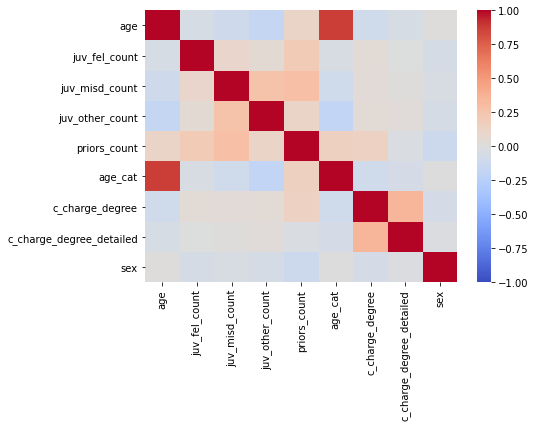

In [101]:
#sns.heatmap(test.corr(), annot=True)
#corr_num = X[feat_numerical].corr()
plt.figure(figsize=(7,5))
sns.heatmap(test.corr(), cmap='coolwarm',vmin=-1, vmax=1);

In [ ]:
# #Select features for Classification model of general recidivism
# # Select age or age_cat, exclude/ include race
# columns_clas = ["id", "age", "age_cat", "sex", "race",  #demographics
#                "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
#                "c_charge_degree", "c_charge_desc", #current charges 
#                "two_year_recid"] #truth

# df_clas = df_clean[columns_clas]

In [ ]:
# #Change dtype for categorical features
# category_cols = ['c_charge_degree', "race", "age_cat", 'score_text', 'sex', 'two_year_recid']
# test_3 = df_clean.copy()
# test_3 = test_3.apply(lambda s: s.astype('category') if s.name in category_cols else s)